In [1]:
!pip install split-folders

In [2]:
import splitfolders
from re import sub
from skimage.io import  imread, imshow
from skimage.transform import  resize, rescale
from skimage.color import rgb2gray
import numpy as np
from os import listdir, path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,os.path
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:

DATA_DIR='/kaggle/input/plantvillage-dataset/color'

In [4]:
os.mkdir('images')

# Make subdirectories train, val, test
os.mkdir(os.path.join('images', 'train'))
os.mkdir(os.path.join('images', 'val'))
os.mkdir(os.path.join('images', 'test'))
# Split the data into folders

splitfolders.ratio(DATA_DIR,output = "images",seed = 101,ratio = (0.80,0.10,0.10))

Copying files: 54305 files [04:00, 225.95 files/s]


In [5]:
TRAIN_PATH = "./images/train"
VAL_PATH = "./images/val"
TEST_PATH  = "./images/test"

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [7]:
train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = (224, 224),
                                          color_mode='rgb',
                                          seed = 123,
                                          batch_size=32,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory =VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = (224, 224),
                                          color_mode='rgb',
                                          seed = 123,
                                          batch_size=32,
                                          shuffle = True)

test_gen = datagen.flow_from_directory(directory =TEST_PATH, 
                                          class_mode="categorical",
                                          target_size = (224, 224),
                                          color_mode='rgb',
                                          batch_size=32,
                                          shuffle = False)

Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


In [8]:
train_dataset = image_dataset_from_directory(DATA_DIR,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=32,
                                             seed = 42,
                                             subset = "training",
                                             image_size=(256,256))

Found 54305 files belonging to 38 classes.
Using 43444 files for training.


In [9]:
class_names = train_dataset.class_names
num_classes = len(class_names)

In [10]:
from keras.applications.mobilenet_v2 import MobileNetV2


model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')

9406464/9406464 [==============================] - 1s 0us/step


In [11]:
model.trainable = False
# Add data augmentation layers
augmentation = tf.keras.Sequential([
   tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), 
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
   tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
   tf.keras.layers.experimental.preprocessing.RandomContrast(0.15),
])
# Here we add final layers to the first model

inputs = model.input
x = augmentation(inputs)

x = BatchNormalization()(model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4, seed=123)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4, seed=123)(x)
x = Flatten()(x)

outputs = Dense(38, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

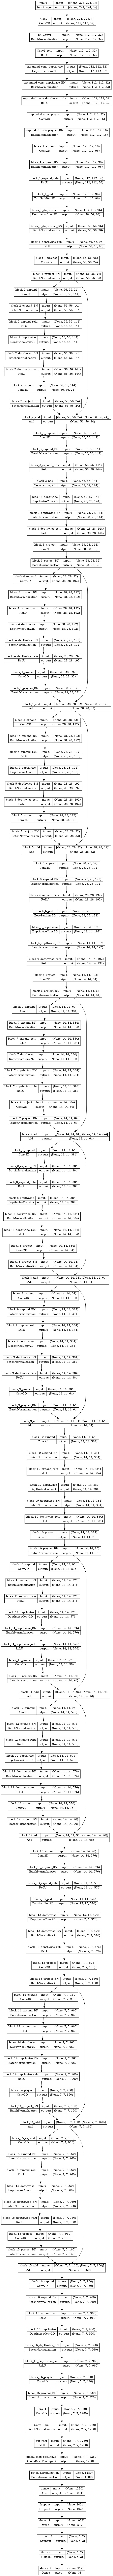

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file= 'model_plot.png', show_shapes = True, show_layer_names=True)

In [16]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 26.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


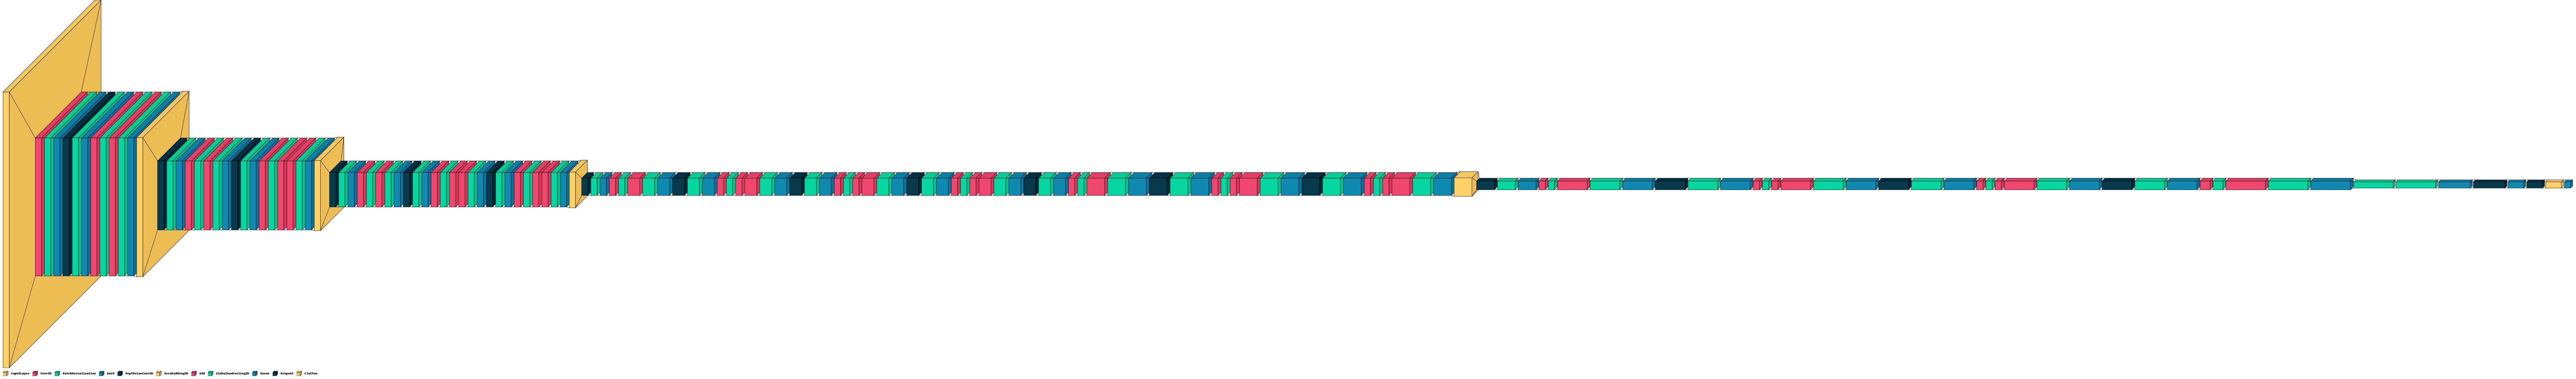

In [17]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [18]:
history = model.fit(train_gen, epochs=7, validation_data=val_gen)


Epoch 1/7
1358/1358 [==============================] - 1105s 811ms/step - loss: 0.5738 - accuracy: 0.8343 - val_loss: 0.2078 - val_accuracy: 0.9348
Epoch 2/7
1358/1358 [==============================] - 1085s 799ms/step - loss: 0.3340 - accuracy: 0.9011 - val_loss: 0.2075 - val_accuracy: 0.9345
Epoch 3/7
1358/1358 [==============================] - 1091s 803ms/step - loss: 0.2642 - accuracy: 0.9221 - val_loss: 0.1708 - val_accuracy: 0.9468
Epoch 4/7
1358/1358 [==============================] - 1079s 794ms/step - loss: 0.2304 - accuracy: 0.9319 - val_loss: 0.1758 - val_accuracy: 0.9454
Epoch 5/7
1358/1358 [==============================] - 1061s 781ms/step - loss: 0.2203 - accuracy: 0.9363 - val_loss: 0.1701 - val_accuracy: 0.9485
Epoch 6/7
1358/1358 [==============================] - 1072s 789ms/step - loss: 0.2085 - accuracy: 0.9423 - val_loss: 0.1709 - val_accuracy: 0.9472
Epoch 7/7
1358/1358 [==============================] - 1085s 799ms/step - loss: 0.1821 - accuracy: 0.9490 - val_

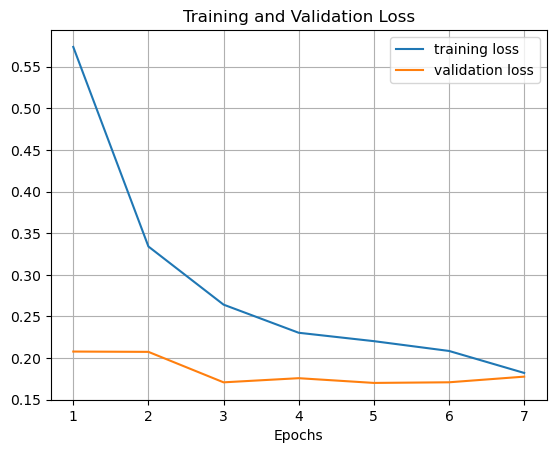

In [19]:
Epochs = [i+1 for i in range(len(history.history['accuracy']))]

plt.plot(Epochs, history.history['loss'], label = 'training loss')
plt.plot(Epochs, history.history['val_loss'], label = 'validation loss')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

In [22]:
evaluation =model.evaluate(test_gen, verbose=1)

171/171 [==============================] - 122s 710ms/step - loss: 0.1907 - accuracy: 0.9489


170/170 [==============================] - 119s 701ms/step


[]

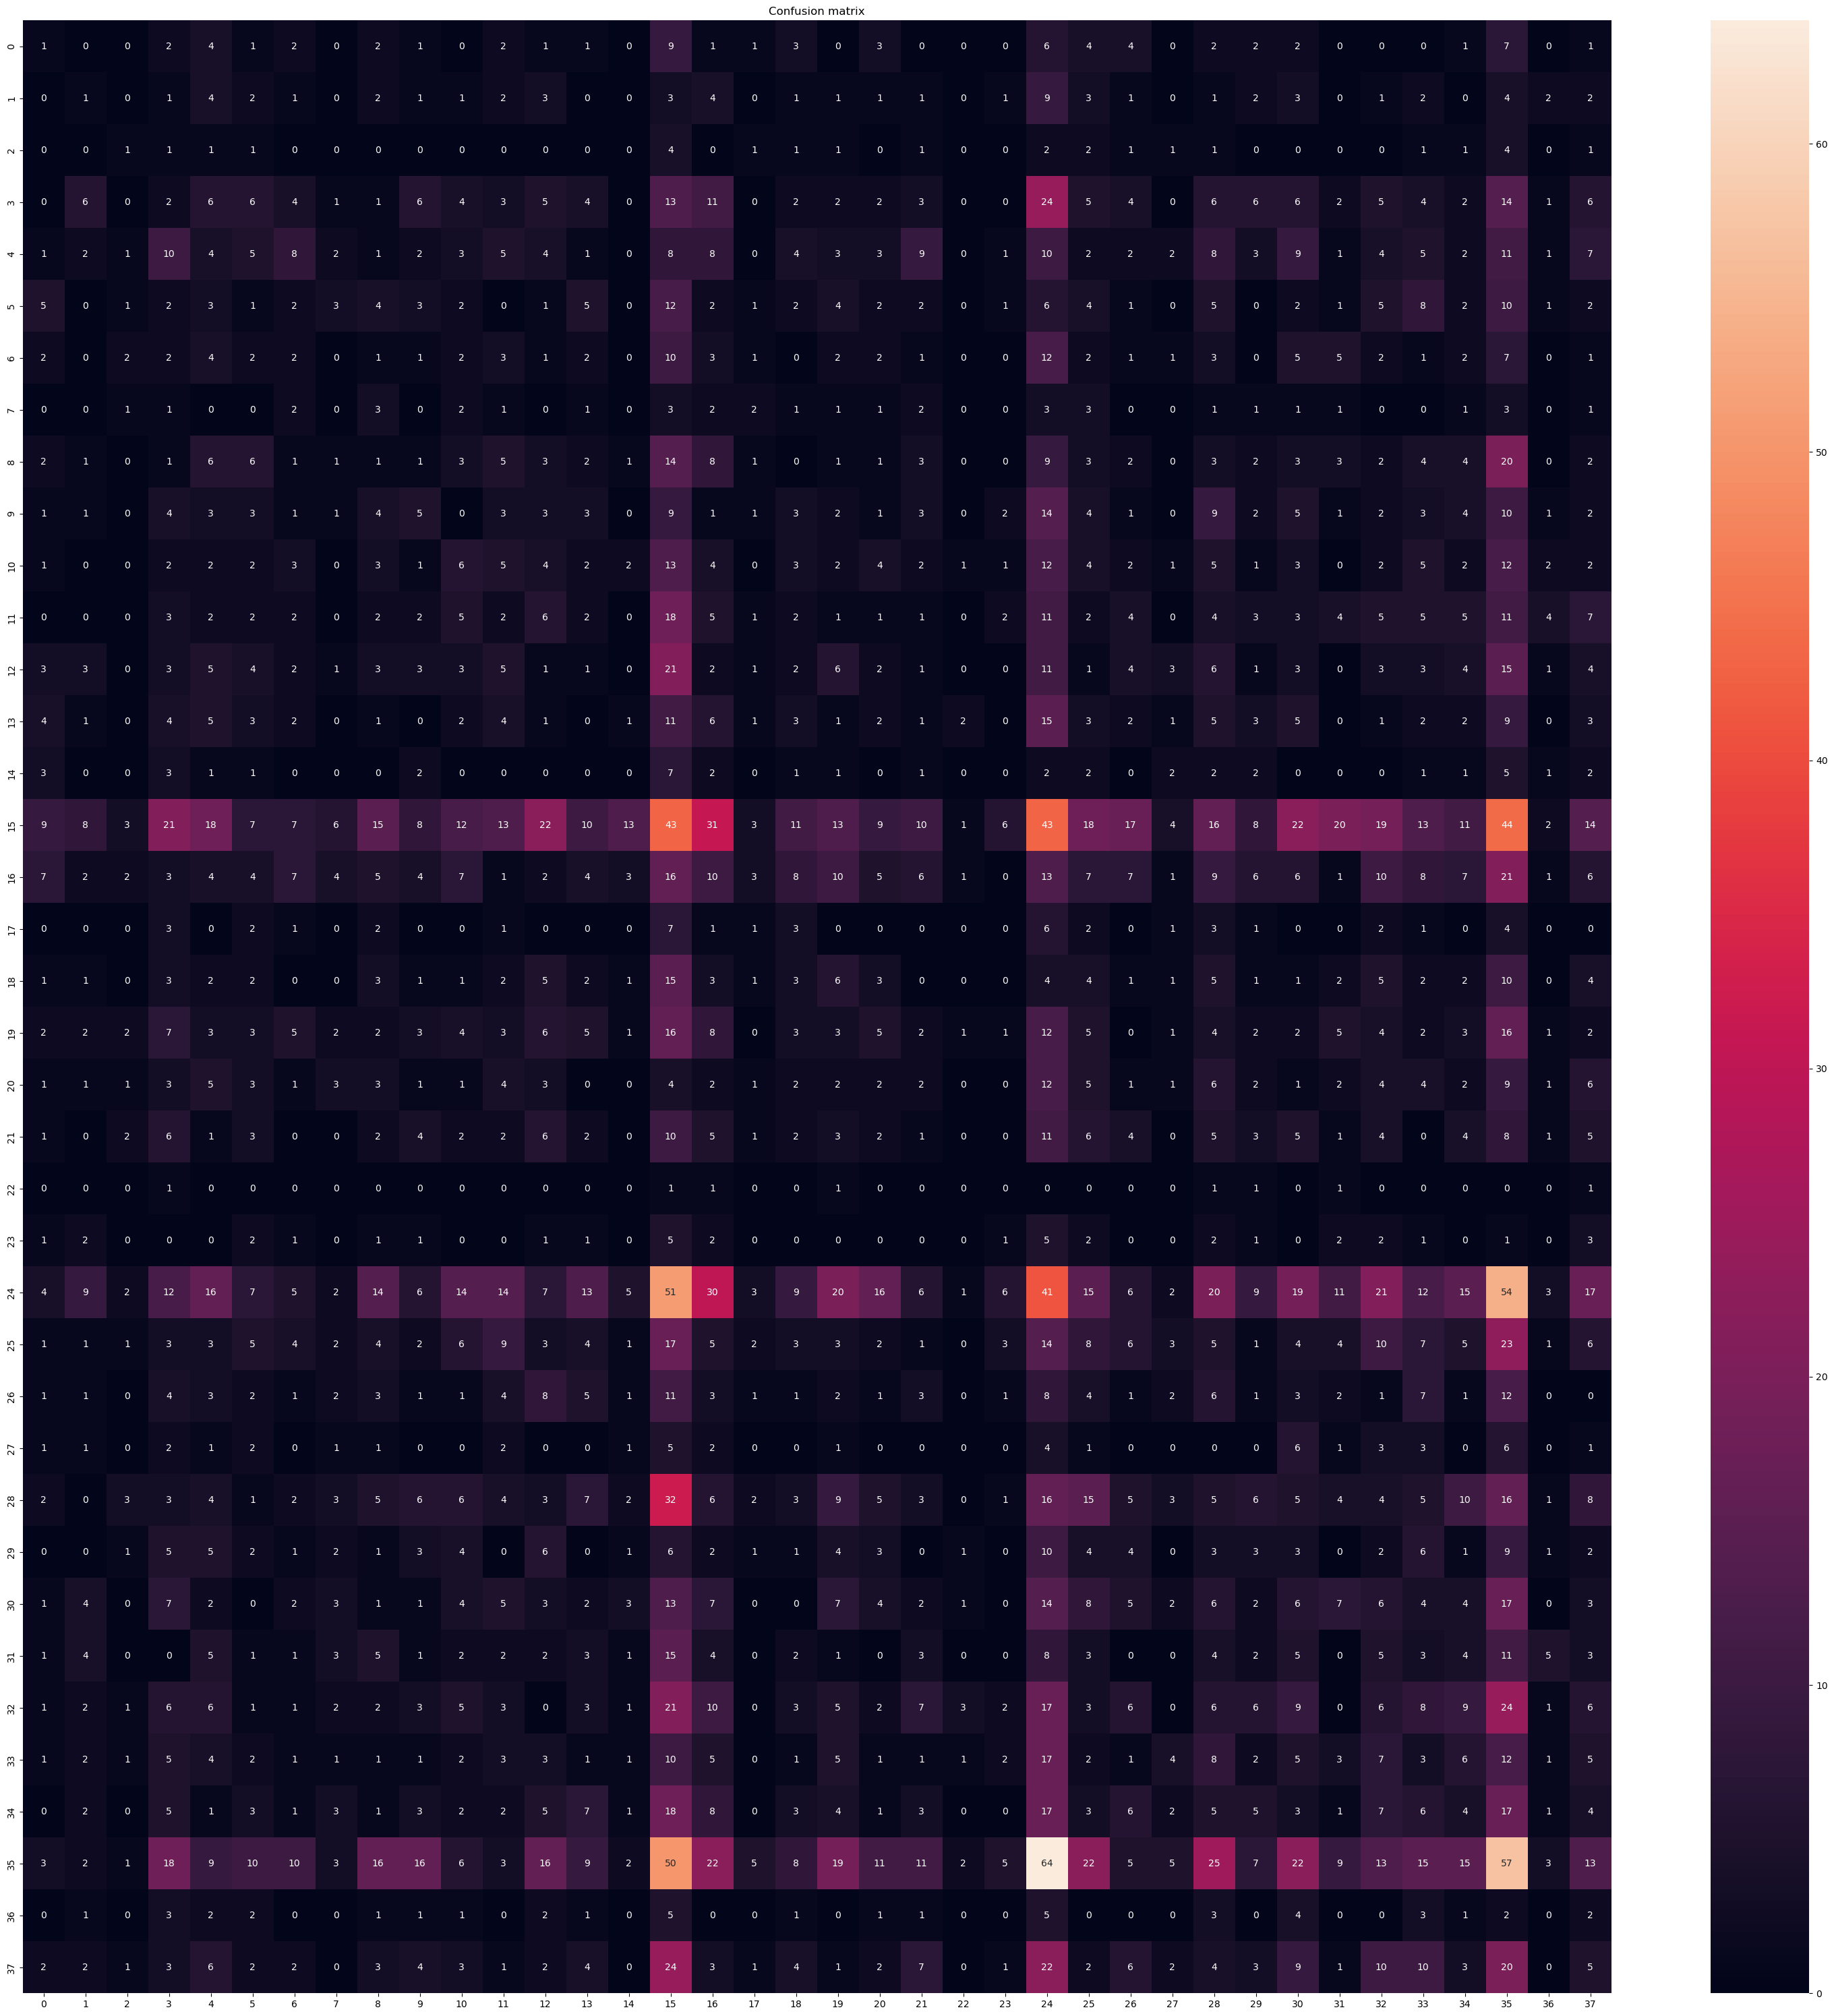

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
p = model.predict(val_gen)
p = np.argmax(p, axis=1)
y_true = val_gen.classes
c = confusion_matrix(p, y_true)

plt.figure(figsize=(38,38))
plt.title('Confusion matrix')
sns.heatmap(c, annot=True)
plt.plot()

In [28]:
model.save("Model.h5")